# Phase-resolved turbulent dissipation

In [2]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from scipy import optimize
from scipy.signal import detrend
import statsmodels.api as sm
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import turbulence as rpt
from roxsi_pyfuns import plotting as rppl

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/' # For laptop
# rootdir = r'/home/malila/ROXSI/Asilomar2022/SmallScaleArray/' # For PC
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))


## 24-h test case. 
Use 2022-07-13 01:00 -- 2022-07-14 01:00, which had the largest tidal range of the experiment as well as relatively stationary $H_\mathrm{s} \approx 1.3$ m and $T\mathrm{p} \approx 9$ s. 

List of processing steps:

1. Identify individual waves from zero crossings of 20-min. Vector surface elevation burst (linear $\kappa_\mathrm{rms}$ transform)​
    - **Check 1**: Only include waves with zero-crossing period longer than 8 sec:​ $T_\mathrm{w} > 8$ sec​
    - Interpolate wave elevation and velocities (16 Hz) to 160-point $0-2 \pi$ phase axis​ (NB: this is done only for ensemble averaging the wave and velocity profiles, not for estimating raw velocity spectra)
    - For turbulence spectra, sub-divide (non-interpolated) phase axis to 8 sub-phases.​
2. For each sub-phase, estimate frequency spectrum from non-interpolated vertical velocity $w$​
    - Convert $f$-spectrum to $k$-spectrum using Taylor's hypothesis with advection speed $U$ defined as the average sub-phase horizontal velocity magnitude (both $u$ and $v$ components)
    - **Check 2**: $U / \mathrm{std}(U)$ must be more than 1 (George et al., 1994; Eq. (6)):​ $U / \mathrm{std}(U)$ > 1​
3. Estimate the dissipation rate $\epsilon$ from (noisy) single $k$-spectrum to get an estimate of the eddy turnover time scale defined as $(l^2 / \epsilon)^{1/3}$, where $l$ is the length scale corresponding to the lowest wavenumber of the best inertial subrange fit​
    - **Check 3**: Eddy turnover time scale must be much larger than advection time scale $(l / U)$: $\tau_\mathrm{eddy} / \tau_\mathrm{adv} > 5$​
    - **Check 4**: the max wavenumber retained in each spectrum needs to be $\mathrm{min}(2 \pi/0.05, \pi f_\mathrm{s}/ U)$, where the second term is the Nyquist wavenumber associated with the sampling frequency. All spectral elements with $k$ greater than this are set to NaN.
4. If first 3 checks are passed, the $k$-spectrum is estimated again, this time interpolated to a predefined 30-point linear $k$-axis ranging from 0.05 m (max. $k$) to 0.5 m (min. $k$). No extrapolation is done beyond pre-defined $k$ range. ​
5. The interpolated spectrum is saved to one of 4 lists corresponding to ranges of $U$:​
    - bin1: ($U$ < 0.15 m/s)
    - bin2: (0.15 < $U$ < 0.3 m/s)
    - bin3: (0.3 < $U$ < 0.45 m/s)
    - bin4: ($U$ > 0.45 m/s)​
6. The interpolated spectra in each $U$ range are ensemble-averaged to produce a single mean spectrum per sub-phase.​
    - **Check 5**: To be included in the mean spectrum, each $k$-band can have max. 20% missing values (NaN). Spectral elements with more NaNs in a given $k$-band are assigned NaN​
7. For each sub-phase and each $U$ range, estimate dissipation rate from ensemble-average spectrum using a linear fit to log-transformed spectrum and wavenumbers. ​
    - Make the fit for all possible $k$-ranges longer than half of the length of the full $k$ axis.​
    - **Check 6**: If the fit has an $\mathrm{R}^2$ score higher than 0.9, save the estimated dissipation rate to a list: $\mathrm{R}^2 > 0.9$​
    - The final dissipation rate for the current sub-phase and $U$ range is the one corresponding to the highest $\mathrm{R}^2$.​
8. When using 4 distinct $U$ ranges, each 20-min burst can give 0--4 different dissipation rate estimates per sub-phase, depending on how many of the spectra pass all the checks outlined above.


C3 - 17219
L1 - 6338


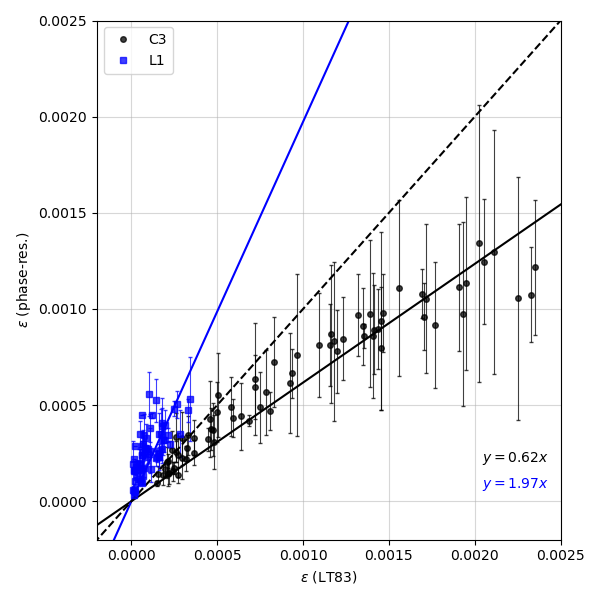

In [19]:
# Serial numbers and corresponding mooring IDs
# mids = ['C2', 'C3', 'C4']
# sers = ['17212', '17219', '17371']
mids = ['C3', 'L1']
sers = ['17219', '6338']
fs = 16 # Sampling freq
# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9
# Minimum ratio of eddy timescale over advection timescale
eddy_adv_ratio = 5
# Sample period
# t0 = pd.Timestamp('2022-07-14 14:00:00')
t0 = pd.Timestamp('2022-07-12 01:00:00')
# t0 = pd.Timestamp('2022-07-15 00:00:00')
nhours = 24 * 3 # No. of hours to process at once
t1 = t0 + pd.Timedelta(hours=nhours)
spd = 60 * 60 * 24 # Seconds per day
# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90, 'C4': None, 'L2': None, 'L1': None}

# Lists for hourly burst averages
wave_int_e = {'{}'.format(m): [] for m in mids} # Interpolated wave elevations
wave_int_u = {'{}'.format(m): [] for m in mids} # Interpolated wave u velocities
wave_int_v = {'{}'.format(m): [] for m in mids} # Interpolated wave v velocities
wave_int_w = {'{}'.format(m): [] for m in mids} # Interpolated wave w velocities
eps_lt83 = {'{}'.format(m): [] for m in mids}
# Dataframes for burst-average dissipation and U_rms
time_range = pd.date_range(t0, t1, freq='1H') # Time index
nt = len(time_range)
dfbd = {'{}'.format(m): pd.DataFrame(data={'eps_phase': np.ones(nt)*np.nan, 
                                           'eps_phase_std': np.ones(nt)*np.nan,
                                           'eps_LT83': np.ones(nt)*np.nan,
                                           'U_rms': np.ones(nt)*np.nan,
                                           'depth': np.ones(nt)*np.nan,
                                           },
                                     index=time_range) for m in mids
                                     }
# dfbu = {'{}'.format(m): pd.DataFrame(data=np.ones(nt)*np.nan, index=time_range) for m in mids}
# # Burst-wide dissipation rates following Lumley & Terray (1983)
# dfbd83 = {'{}'.format(m): pd.DataFrame(data=np.ones(nt)*np.nan, index=time_range) for m in mids}
# Dissipation rates per wave-cycle subsegment
diss_subseg = {'{}'.format(m): {} for m in mids}
U_subseg = {'{}'.format(m): {} for m in mids}
for mid in mids:
    diss_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
    U_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# Wave-by-wave dissipation rates lists for concatenating dataframes
dfw_list = {'{}'.format(m): [] for m in mids}


# Define type of fit to use for dissipation rate calculation
fit = 'linear'
# Define number of bins to use for advection speed U (1-4)
nbins = 4
if nbins == 2:
    # Define U ranges for 2 bins
    ubins = [(0, 0.5), (0.5, 2)]
elif nbins == 3:
    # Define U ranges for 3 bins
    ubins = [(0, 0.25), (0.25, 0.5), (0.5, 2)]
elif nbins == 4:
    # Define U ranges for 4 bins
    ubins = [(0, 0.15), (0.15, 0.3), (0.3, 0.45), (0.45, 2)]

# Test plot 1, ensemble-avg k-spectra and -5/3 fits for each burst
plot1 = True
# Plot 2: ensemble-avg wave and w profiles + epsilon box plots
plot2 = True
# Plot 3: scatter plot of epsilon vs. U_rms^3
plot3 = True
# Plot 4: scatter plot of U_rms^3 comparison (C3 vs. L1)
plot4 = True
# Plot 5: scatter plot of epsilon comparison (phase-res. vs. LT83)
plot5 = True

# Iterate over C2, C3, C4 moorings
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

    # Filename of burst diss. rate csv file
    csvdir = os.path.join(ncdir, 'dissipation_rate')
    if not os.path.isdir(csvdir):
        os.mkdir(csvdir)
    fn_csv_diss = os.path.join(csvdir, 'burst_diss_{}_{}_nhours_{}.csv'.format(
        mid, t0.strftime('%Y%m%d_%H%M'), nhours))
    if not os.path.isfile(fn_csv_diss):
        # Wave counter
        wcnt = 0
        # Iterate over bursts
        for t0b in time_range:
            t1b = t0b + pd.Timedelta(hours=1)
            if t1b > t1:
                continue
            # print('{}-{}'.format(t0b, t1b.time()))
            # Select sample period
            seg = dsv.sel(time=slice(t0b, t1b))
            eta = seg.eta_lin_krms.copy().to_series() # Surface elevation

            # Convert velocities to cross-/alongshore
            # x vel, despiked
            uxd = seg.uxd.to_dataframe() # Convert to pandas
            uxd = uxd.interpolate(method='bfill').interpolate('ffill')
            uxm = uxd.mean().item()
            uxd -= uxm
            # y vel, despiked
            uyd = seg.uyd.to_dataframe() # Convert to pandas
            uyd = uyd.interpolate(method='bfill').interpolate('ffill')
            uym = uyd.mean().item()
            uyd -= uym
            # z vel, despiked
            uzd = seg.uzd.to_dataframe() # Convert to pandas
            uzd = uzd.interpolate(method='bfill').interpolate('ffill')
            uzd -= uzd.mean()
            # Rotate velocities to cross/alongshore & vertical using PCA
            ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                            uy=uyd.values.squeeze(), 
                                            uz=uzd.values.squeeze(),
                                            heading_exp=heading_exp[mid], 
                                            # print_msg=True,
                                            )
            # Estimate U-rms for burst
            uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
            vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
            # Variance of cross- and alongshore orbital velocities
            m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
            m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
            Urms = np.sqrt(2 * (m0u + m0v))
            # Mean current
            Uburst = np.sqrt(uxm**2 + uym**2)
            # Mean depth
            h = seg.z_hyd.mean().item()
            # Estimate full w-spectrum (testing)
            wspec = rpws.spec_uvz(uw, fs=16, fmerge=5)

            # Estimate full burst dissipation rate following 
            # Lumley & Terray (1983) and Trowbridge & Elgar (2001)
            eps, r2, cf = rpt.dissipation_rate_LT83(f=wspec.freq.values.squeeze(),
                                                    spec=wspec.Ezz.values.squeeze(),
                                                    U=Uburst, sigma=np.sqrt(m0u+m0v),
                                                    skip_f=10)
            eps_lt83[mid].append(eps)
            dfbd[mid]['eps_LT83'].loc[t0b] = eps
            # dfbd83[mid].loc[t0b] = eps

            # Get zero-crossings, min. 4-sec waves
            zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
            nwaves = len(Hw)
            # Compute H(1/3)
            Hws = np.sort(Hw) # Sorted wave heights
            H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
            # Define phase (x) axis to interpolate to
            n_phase = 160 # Number of points in phase axis
            min_period = 6 # Min. wave period (sec) to include

            # Lists for storing dataframes of spectral segments for merging
            # for different ranges of advection speed U
            dfsi_lists_1 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dfsi_lists_2 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dfsi_lists_3 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dfsi_lists_4 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dssi = {'q{}'.format(n): [] for n in range(1,ncyc+1)}
            # Check if spectral datasets saved to netcdf
            spec_ncdir = os.path.join(ncdir, 'k_specs')
            if not os.path.isdir(spec_ncdir):
                os.mkdir(spec_ncdir)
            csvdir_phase = os.path.join(ncdir, 'phase_res_int')
            if not os.path.isdir(csvdir_phase):
                os.mkdir(csvdir_phase)
            # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
            for zi,zc0 in enumerate(zc[:-1]):
                # Only include waves with T > min_period sec
                Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
                if Tw < min_period:
                    continue
                # Also only include high waves
                Hwi = Hw[zi]
    #             if Hwi < H13:
    #                 continue
                # Wave surface elevation, u, v and w for current wave
                eta_wave = eta.iloc[zc0:zc[zi+1]]
                u_wave = ucs[zc0:zc[zi+1]]
                v_wave = uls[zc0:zc[zi+1]]
                w_wave = uw[zc0:zc[zi+1]]
                # Surface elevation interpolation
                df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                              label='eta_int_{:04d}'.format(wcnt))
                wave_int_e[mid].append(df_e)
                # Save to csv
                fn_csv_dfe = os.path.join(csvdir_phase, 
                                          'e_int_{}_{}_{:04d}.csv'.format(
                                              mid, t0b.strftime('%Y%m%d_%H%M'), wcnt))
#                 if not os.path.isfile(fn_csv_dfe):
#                     df_e.to_csv(fn_csv_dfe)
                # Cross-shore vel. interpolation
                df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                            label='u_int_{:04d}'.format(wcnt))
                wave_int_u[mid].append(df_u)
                # Save to csv
                fn_csv_dfu = os.path.join(csvdir_phase, 
                                          'u_int_{}_{}_{:04d}.csv'.format(
                                              mid, t0b.strftime('%Y%m%d_%H%M'), wcnt))
#                 if not os.path.isfile(fn_csv_dfu):
#                     df_u.to_csv(fn_csv_dfu)
                # Long-shore vel. interpolation
                df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                            label='u_int_{:04d}'.format(wcnt))
                wave_int_v[mid].append(df_v)
                # Save to csv
                fn_csv_dfv = os.path.join(csvdir_phase, 
                                          'v_int_{}_{}_{:04d}.csv'.format(
                                              mid, t0b.strftime('%Y%m%d_%H%M'), wcnt))
#                 if not os.path.isfile(fn_csv_dfv):
#                     df_v.to_csv(fn_csv_dfv)
                # Vertical vel. interpolation
                df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                            label='u_int_{:04d}'.format(wcnt))
                wave_int_w[mid].append(df_w)
                # Save to csv
                fn_csv_dfw = os.path.join(csvdir_phase, 
                                          'w_int_{}_{}_{:04d}.csv'.format(
                                              mid, t0b.strftime('%Y%m%d_%H%M'), wcnt))
#                 if not os.path.isfile(fn_csv_dfw):
#                     df_w.to_csv(fn_csv_dfw)
                # Also make df of non-interpolated vert. vel. with phase axis
                phase_ni = np.linspace(0, 1, len(w_wave)) #* 2*np.pi # non-int. phases
                df_wni = pd.DataFrame(data=w_wave.squeeze(), index=phase_ni)
                # Save to csv
                fn_csv_dfwni = os.path.join(csvdir_phase, 
                                            'w_nonint_{}_{}_{:04d}.csv'.format(
                                                mid, t0b.strftime('%Y%m%d_%H%M'), wcnt))
#                 if not os.path.isfile(fn_csv_dfwni):
#                     df_wni.to_csv(fn_csv_dfwni)
                # Increase wave counter
                wcnt += 1

                # Estimate spectra for 1/ncyc wave cycles
                nsub = n_phase // ncyc # no. of samples per phase sub-segment
                nsub_ni = len(phase_ni) // ncyc # non-interpolated # of samples
                # Frequencies
                n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
                n_freqs_ni = int(np.floor(nsub_ni / 2 )) # No. of frequency bands
                # Wavenumbers to interpolate spectrum to
                n_int = 30 # Number of wavenumbers to interpolate to
                kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
                kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
                ki = np.linspace(kmin, kmax, n_int) # Interp. target k's
                # Initialize dict to store spectral dataframes (incl. U)
                dfsi = {} # k-spec dataframes
                for nb in range(1, nbins+1):
                    dfsi['{}'.format(nb)] = {}

                for i in range(ncyc):
                    # Get short-segment interpolated velocities
                    useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    # Also get non-interpolated vertical velocity segment
                    wseg_ni = df_wni.iloc[i*nsub_ni:(i+1)*nsub_ni].values.squeeze()
                    # Timestamp
                    t0seg = (pd.Timestamp(eta_wave.index[0]) + 
                            pd.Timedelta(seconds=(Tw/n_int)*(i/ncyc)))
                    # Compute mean current and check that U >> dU for segment
                    U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
                    umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
                    dU = np.std(umag) # Variability in umag (following George et al., 1994)
                    # Check U/dU ratio
                    if (U / dU) < 1:
                        # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                        # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), 
                        # Fig. 9
                        continue
                    # Check that the turnover timescale of the eddies is much longer 
                    # than the time for advection of the eddies past the sensor.
                    # First estimate k spectrum of w following George et al. (1994)
                    dsk_i = rpt.k_spec_wavephase(w=wseg_ni, U=U)
                    # Check highest allowable k based on sampling rate and volume
                    maxk_check = np.min((kmax, np.pi*fs/U))
                    # Set to NaN all spectral elements with k > maxk
                    dsk_i.k_spec.values = dsk_i.k_spec.where(dsk_i.k < maxk_check).values
                    # Make (noisy) first estimate of dissipation rate from single
                    # spectrum for eddy time scale
                    rs_list = [] # R^2 values of fits
                    eps_list = [] # Dissipation rate estimates from fits
                    si_list = [] # Start indices of fits (to get lowest k of best fit)
                    sis = np.arange(1, n_freqs_ni//2) # Start indices of -5/3 fit
                    eis = -np.arange(1, n_freqs_ni//2)[::-1] # End indices of fit
                    # Iterate over different k ranges and fit inertial subrange
                    for si in sis:
                        for ei in eis:
                            N = len(dsk_i.k.values[si:ei])
                            if N < n_freqs_ni // 2:
                                # Don't try to fit to less than half of 
                                # available points
                                continue
                            # No NaNs allowed
                            if np.any(np.isnan(dsk_i.k_spec.values.squeeze()[si:ei])):
                                continue
                            # Get diss. rate and R^2 of inertial subrange fit to 
                            # spectrum segment
                            epsilon, r_squared, coeff = rpt.dissipation_rate(
                                k=dsk_i.k.values[si:ei], 
                                spec=dsk_i.k_spec.values.squeeze()[si:ei], 
                                fit=fit)
                            # Save R^2 and epsilon to dict
                            rs_list.append(r_squared)
                            eps_list.append(epsilon)
                            si_list.append(si)
                    # Find best fit from R^2 (highest) and fit length (longest)
                    if len(rs_list) == 0:
                        # No fits were made (too many NaNs)
                        continue
                    # Get index of max. R^2
                    max_rsq_ind = np.argmax(rs_list)
                    # Use dissipation rate estimate with highest R^2 value
                    eps_est = eps_list[max_rsq_ind]
                    # Use lowest k included in the best fit
                    sim = si_list[max_rsq_ind]
                    l = 2*np.pi / dsk_i.k.values[sim]
                    # Compute eddy time scale (Eq. 6.11 of Pope, pg. 187)
                    t_eddy = (l**2 / eps_est)**(1/3)
                    # Compute advection time scale
                    t_adv = l / U
                    # Check t_eddy vs. t_adv criterion, only save spectrum
                    # for later ensemble averaging if ratio high enough
                    if (t_eddy / t_adv) < eddy_adv_ratio:
                        # Ratio too low -> don't save spectrum
                        continue
                    # Estimate new k-spectrum and interpolate to pre-defined k axis
                    dsk = rpt.k_spec_wavephase(w=wseg_ni, U=U, k_int=ki)
                    # Add wave height and wave counter as variable
                    dsk['Hw'] = ([], Hwi)
                    dsk['wcnt'] = ([], wcnt)
                    # Add time coordinate to spectrum dataset
                    dsk = dsk.assign_coords(time=[t0seg])
                    # Check highest allowable k
                    maxk = np.min((2*np.pi/0.05, np.pi*fs/U))
                    # Set to NaN all spectral elements with k > maxk
                    dsk.k_spec.values = dsk.k_spec.where(dsk.k < maxk).values
                    # Append to list
                    dssi['q{}'.format(i+1)].append(dsk)

            # Concatenate spectral datasets and save to netcdf
            dss = {} # Datasets to concatenate
            for n in range(1, ncyc+1):
                # Check if nc file already saved
                fn_kspec_nc = os.path.join(spec_ncdir, 'kspec_{}_{}_{}.nc'.format(
                    mid, 'q{}'.format(n), t0b.strftime('%Y%m%d_%H%M')))
                if os.path.isfile(fn_kspec_nc):
                    dss['q{}'.format(n)] = xr.open_dataset(fn_kspec_nc, 
                                                           decode_cf=True)
                else:
                    dss['q{}'.format(n)] = xr.concat(
                            dssi['q{}'.format(n)], dim='time')
                    # Save to netcdf
                    if not os.path.isfile(fn_kspec_nc):
                        dss['q{}'.format(n)].to_netcdf(fn_kspec_nc)

            # Dicts to store curve fit coeff.
            rsqs = {} # R^2 value for best fit
            coeffs = {} # Fit coefficient for best fit
            sid = {} # Optimal start index for fit
            eid = {} # Optimal end index for fit
            diss_rate = {}
            U_diss = {}
            # Define figure filename
            figdir_spec = os.path.join(figdir, 'turb_spec')
            if not os.path.isdir(figdir_spec):
                os.mkdir(figdir_spec)
            fn_fig = os.path.join(figdir_spec, 'kspec_{}_{}_ubins_{}_fit_{}.png'.format(
                mid, t0b.strftime('%Y%m%d_%H%M'), nbins, fit))
            # Initialize test plot 1, k-spectra and -5/3 fits
            if plot1 and not os.path.isfile(fn_fig):
                # Define fit function
                def fun(x, c):
                    """
                    Standard curve fit to inertial subrange k^{-5/3}.
                    """
                    return c * x ** (-5/3)
                nrows = ncyc//4
                fig, axes = plt.subplots(figsize=(7,2.5*nrows), 
                    ncols=4, nrows=nrows, sharex=True, sharey=True)
                csu = ['C0', 'C1', 'C2', 'C3'] # Colors for plot
            # Iterate over sub-sections
            for n in range(1, ncyc+1):
                # Iterate over U ranges defined by nbins
                for ui in range(nbins):
                    # Select correct dataset
                    dsi = dss['q{}'.format(n)].copy()
                    # Select correct U range if using more than 1 U bin
                    if nbins > 1:
#                         dsi = dsi.where(
#                             np.logical_and(dsi.U>=ubins[ui][0], dsi.U<ubins[ui][1]), 
#                             drop=True,
#                             )
                        dsi = dsi.isel(
                            time=np.logical_and(
                                dsi.U>=ubins[ui][0], dsi.U<ubins[ui][1]))
                        # Check that the selected U range has data
                        if len(dsi.time) == 0:
                            continue
                    # Average spectra for wavenumbers with no more than maxnan 
                    # fraction of NaN values
                    maxnan = 0.2 # Max. allowed fraction of NaNs per wavenumber
                    good_inds = (dsi.k_spec.isnull().sum(dim='time')/len(dsi.time)<=maxnan)
                    ps_mean = dsi.where(good_inds).mean(dim='time').k_spec.values
                    # Also get corresponding U values
                    U_mean = dsi.where(good_inds).U.mean(dim=['k', 'time']).item()
                    # Lists to store curve fit coeff.
                    rsqs_i = [] # R^2 value for best fit
                    coeffs_i = [] # R^2 value for best fit
                    sid_i = [] # Optimal start index for fit
                    eid_i = [] # Optimal end index for fit
                    npts = [] # Number of points to fit
                    diss_i = [] # Dissipation rates
                    U_i = [] # rms velocities
                    # Iterate over different start/end freq. indices for fit
                    # Disregard first (0-th) wavenumber
                    sis = np.arange(1, n_int//2) # Start indices of fits
                    eis = -np.arange(1, n_int//2)[::-1] # End inds of fits
                    for si in sis:
                        for ei in eis:
                            N = len(ki[si:ei])
                            if N < n_int // 2:
                                # Don't try to fit to less than half of 
                                # available points
                                continue
                            # No NaNs allowed
                            if np.any(np.isnan(ps_mean[si:ei])):
                                continue
                            # Get diss. rate and R^2 of inertial subrange fit to 
                            # spectrum segment
                            epsilon, r_squared, coeff = rpt.dissipation_rate(
                                k=ki[si:ei], spec=ps_mean[si:ei], fit=fit)
                            # Save to dict if R^2 high enough
                            if r_squared >= r2_thresh:
                                rsqs_i.append(r_squared)
                                coeffs_i.append(coeff)
                                diss_i.append(epsilon)
                                sid_i.append(si)
                                eid_i.append(ei)
                                npts.append(N)
                                U_i.append(U_mean)
                    # Find best fit from R^2 (highest) and fit length (longest)
                    if len(rsqs_i) == 0:
                        # No fits were made (too many NaNs)
                        continue
                    max_rsq_ind = np.argmax(rsqs_i)
                    # Save parameters corresponding to max R^2
                    diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
                    rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
                    coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
                    U_diss['q{}'.format(n)] = U_i[max_rsq_ind]
                    sid['q{}'.format(n)] = sid_i[max_rsq_ind]
                    eid['q{}'.format(n)] = eid_i[max_rsq_ind]
                    # Also append to ensemble-avg list
                    diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                        diss_i[max_rsq_ind])
                    U_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                        U_i[max_rsq_ind])
                    # Plot spectra and -5/3 fits for each wave-phase 
                    # subsegment?
                    if plot1 and not os.path.isfile(fn_fig):
                        # Check is current segment has data to plot
                        if 'q{}'.format(n) in sid.keys():
                            si = sid_i[max_rsq_ind]
                            ei = eid_i[max_rsq_ind]
                            rsq = rsqs_i[max_rsq_ind]
                            cf = coeffs_i[max_rsq_ind]
                            diss = diss_i[max_rsq_ind]
                            ax = axes.flat[n-1]
                            dsi.k_spec.isel(k=slice(1, None)).mean(dim='time').plot(
                                ax=ax, c=csu[ui], label='ubin {}'.format(ui+1))
                            ax.loglog(ki[si:ei], fun(ki[si:ei], cf), 
                                linestyle='--', color='k')
                            if nbins == 1:
                                # Annotate R^2
                                ax.annotate(r'$R^2$='+'{:.2f}'.format(rsq), xy=(0.05, 0.03), 
                                            xycoords='axes fraction', fontsize=9)
                                # Annotate dissipation rate
                                ax.annotate(r'$\epsilon$='+'{:.2E}'.format(diss), 
                                            xy=(0.05, 0.11), xycoords='axes fraction', 
                                            fontsize=9)

            if plot1 and not os.path.isfile(fn_fig):
                # Labels & ticks
                for ax in axes[1,:]:
                    ax.set_xlabel(r'$k$ [rad/m]')
                    ax.set_xlim([10, 200])
                    ax.set_ylim([1e-7, 1e-3])
                    ax.set_xticks([10, 100])
                    # ax.get_xaxis().get_major_formatter().labelOnlyBase = False
                    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
                for ax in axes[:,0]:
                    ax.set_ylabel(r'$\phi(k)$ [$(\mathrm{m}^2\mathrm{s}^{-2})$/(rad/m)]')
                # Set log-log axes
                for na, ax in enumerate(axes.flat):
                    if ax.lines:
                        # Legend if not empty plot (to avoid warnings)
                        ax.legend(fontsize=8)

                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    # Annotate sub segment number
                    ax.annotate('{}/{}'.format(na+1, ncyc), xy=(0.03, 0.88), 
                                xycoords='axes fraction', fontsize=14)
                plt.suptitle('{} {}, # of U-bins: {}, fit: {}'.format(
                    mid, t0b, nbins, fit))
                plt.tight_layout()
                # plt.show()
                plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
                plt.close()
            # Save burst-average dissipation and U_rms
            dfbd[mid]['eps_phase'].loc[t0b] = np.array(list(diss_rate.values())).mean()
            dfbd[mid]['eps_phase_std'].loc[t0b] = np.array(list(
                diss_rate.values())).std()
            dfbd[mid]['U_rms'].loc[t0b] = Urms
            dfbd[mid]['depth'].loc[t0b] = h
            # dfbu[mid].loc[t0b] = Urms / h
        # Save to csv
        dfbd[mid].index = dfbd[mid].index.rename('time')
        dfbd[mid].to_csv(fn_csv_diss)

    else:
        dfbd[mid] = pd.read_csv(fn_csv_diss, parse_dates=['time']).set_index('time')


# Average wave phase vs. dissipation rate plot
cs = ['k', 'b', 'r']
lss = ['-', '--', ':']
mstr = ''.join(mids) # String joining all mooring IDs for figure fname
fn_fig_2 = os.path.join(figdir, 
    'ens_avg_diss_{}_{}_{}h_ubins_{}_fit_{}.pdf'.format(
        mstr, t0.strftime('%Y%m%d_%H%M'), nhours, nbins, fit))
if plot2 and not os.path.isfile(fn_fig_2):
    # Concatenate interpolated wave variables dataframes
    # df_ei = {'{}'.format(m): [] for m in mids}
    df_ei = {}
    df_ui = {}
    df_vi = {}
    df_wi = {}
    print('Concatenating wave elevation and velocity dataframes ...')
    for mid in mids:
        ncdir = os.path.join(vec_root, mid)
        csvdir_phase = os.path.join(ncdir, 'phase_res_int')
        fn_csv_ei = os.path.join(csvdir_phase, 'eta_int_concat_{}_{}_nhours_{}.csv'.format(
            mid, t0.strftime('%Y%m%d_%H%M'), nhours))
        if os.path.isfile(fn_csv_ei):
            df_ei[mid] = pd.read_csv(fn_csv_ei, index_col=0)
        else:
            df_ei[mid] = pd.concat(wave_int_e[mid], axis=1) # Interp. surf. elev.
        fn_csv_ui = os.path.join(csvdir_phase, 'u_int_concat_{}_{}_nhours_{}.csv'.format(
            mid, t0.strftime('%Y%m%d_%H%M'), nhours))
        if os.path.isfile(fn_csv_ui):
            df_ui[mid] = pd.read_csv(fn_csv_ui, index_col=0)
        else:
            df_ui[mid] = pd.concat(wave_int_u[mid], axis=1) # Interp. cs vel.
        fn_csv_vi = os.path.join(csvdir_phase, 'v_int_concat_{}_{}_nhours_{}.csv'.format(
            mid, t0.strftime('%Y%m%d_%H%M'), nhours))
        if os.path.isfile(fn_csv_vi):
            df_vi[mid] = pd.read_csv(fn_csv_vi, index_col=0)
        else:
            df_vi[mid] = pd.concat(wave_int_v[mid], axis=1) # Interp. ls vel.
        fn_csv_wi = os.path.join(csvdir_phase, 'w_int_concat_{}_{}_nhours_{}.csv'.format(
            mid, t0.strftime('%Y%m%d_%H%M'), nhours))
        if os.path.isfile(fn_csv_wi):
            df_wi[mid] = pd.read_csv(fn_csv_wi, index_col=0)
        else:
            df_wi[mid] = pd.concat(wave_int_w[mid], axis=1) # Interp. vertical vel.
        # Save to csv
        if not os.path.isfile(fn_csv_ei):
            df_ei[mid].to_csv(fn_csv_ei)
        if not os.path.isfile(fn_csv_ui):
            df_ui[mid].to_csv(fn_csv_ui)
        if not os.path.isfile(fn_csv_vi):
            df_vi[mid].to_csv(fn_csv_vi)
        if not os.path.isfile(fn_csv_wi):
            df_wi[mid].to_csv(fn_csv_wi)
    fig, axes = plt.subplots(figsize=(5,6), nrows=3, sharex=True)
    for ax in axes:
        # Mark subsections
        for nc in np.arange(ncyc)[::2]:
            ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='gray', 
                       alpha=0.25)
    # Iterate over moorings
    for m, mid in enumerate(mids):
        # Ensemble-avg eta on top, with +/- 1*std errorbars
        axes[0].errorbar(df_ei[mid].index, df_ei[mid].mean(axis=1), 
            ls=lss[m], yerr=df_ei[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20), label=mid)
        # Ensemble-avg w in middle, with +/- 1*std errorbars
        axes[1].errorbar(df_wi[mid].index, df_wi[mid].mean(axis=1), 
            ls=lss[m], yerr=df_wi[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20))
        # Dissipation rates per wave-phase subsection
        for n in range(1, ncyc+1):
            # All epsilon values for current phase subsection
            eps = diss_subseg[mid]['{}/{}'.format(n, ncyc)]
            # Centered x-locations
            position = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/16)*(2-(m+1))]
            # Box plot of epsilon range
            # axes[2].boxplot(x=eps, positions=positions, color=cs[m])
            rppl.box_plot(ax=axes[2], data=eps, positions=position, 
                edge_color=cs[m], fill_color='white', showfliers=False)

    # Set x axis labels as multiples of pi
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # Grid
        ax.grid(alpha=0.5)

    # Axis labels
    axes[0].set_title('{}-{}'.format(t0, t1))
    axes[0].set_ylabel(r'$\langle \zeta \rangle$ [m]')
    axes[1].set_ylabel(r'$\langle w \rangle$ [m/s]')
    axes[2].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

    # axes[2].set_title('# of U-bins: {}'.format(nbins))

    # Legend on top row
    handles, labels = axes[0].get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    axes[0].legend(handles, labels, loc='upper right')

    # Set dissipation rate y scale to log
    axes[2].set_yscale('log')
    axes[2].set_ylim([1e-6, 1e-2])

    plt.tight_layout()
    # plt.show()
    plt.savefig(fn_fig_2, bbox_inches='tight', dpi=300)
    plt.close()

# Scatter plot of epsilon vs U_rms^3
fn_fig_3 = os.path.join(figdir,  
    'eps_vs_urms_{}_{}_{}h_ubins_{}_fit_{}.pdf'.format(
        mstr, t0.strftime('%Y%m%d_%H%M'), nhours, nbins, fit))
if plot3 and not os.path.isfile(fn_fig_3):
    fig, ax = plt.subplots(figsize=(5,5))
    cs = ['k', 'b', 'r']
    ms = ['o', 's', '^']
    for mi, mid in enumerate(mids):
        x = (dfbd[mid]['U_rms']**3).to_frame()
        y = dfbd[mid]['eps_phase']
        ystd = dfbd[mid]['eps_phase_std']
        # Least squares fit, see:
        # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
        # Force intercept to be 0, see:
        # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
        model = sm.OLS(y, x.assign(intercept=0), missing='drop')
        results = model.fit()
        m, b = results.params
        # print(results.params)
        # ax.scatter(x, y, color=cs[mi], label=mid, marker=ms[mi])
        ax.errorbar(x, y, yerr=ystd, color=cs[mi], label=mid, fmt=ms[mi],
                    capsize=1.5, ms=5, alpha=0.75, elinewidth=0.8)
        # Plot least squares fit
        ax.axline(xy1=(0, b), slope=m, color=cs[mi], linestyle='--')
        # Annotate least squares function
        s = f'$y = {m:.4f}x$'# {b:+.4f}$'
        ax.annotate(s, xy=(0.65, 0.10-mi*0.05), xycoords='axes fraction', 
                    color=cs[mi])
    # Labels
    ax.set_xlabel(r'$U_\mathrm{rms}^3$ $[\mathrm{m}^3 \mathrm{s}^{-3}]$')
    ax.set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')
    ax.set_title('{}-{}'.format(t0, t1))

    ax.set_xlim([0, None])
    ax.set_ylim([0, None])

    # Legend markers without errorbars
    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    ax.legend(handles, labels, loc='upper left')

    plt.tight_layout()
    # plt.show()
    plt.savefig(fn_fig_3, bbox_inches='tight', dpi=300)
    plt.close()
    # plt.clf()

# Scatter plot of U_rms^3 C3 vs. L1 (or other combination)
if len(mids) == 2:
    fn_fig_4 = os.path.join(figdir,  
        'urms_scatter_{}_{}_{}h_ubins_{}_fit_{}.pdf'.format(
            mstr, t0.strftime('%Y%m%d_%H%M'), nhours, nbins, fit))
    if plot4 and not os.path.isfile(fn_fig_4):
        fig, ax = plt.subplots(figsize=(5,5))
        cs = ['k', 'b', 'r']
        ms = ['o', 's', '^']
        # Scatter plot U_rms C3 vs. L1
        y = dfbd['C3']['U_rms'].to_frame()
        x = dfbd['L1']['U_rms'].to_frame()
        # Least squares fit, see:
        # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
        # Force intercept to be 0, see:
        # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
        model = sm.OLS(y, sm.add_constant(x), missing='drop')
        results = model.fit()
        b, m = results.params
        # print(results.params)
        ax.scatter(x, y, color='k', alpha=0.75)
        # Plot least squares fit
        s = f'$y = {m:.2f}x + {b:+.2f}$' # Line label
        # ax.axline(xy1=(0, b), slope=m, color='k', linestyle='-', label=s)
        # One-to-one line
        xl = np.linspace(0, 1)
        ax.plot(xl, xl, color='k', linestyle='--', label=r'$y = x$')
        # Labels
        ax.set_xlabel(r'$U_\mathrm{rms}$ ' + mids[1] + r' $[\mathrm{m} \mathrm{s}^{-1}]$')
        ax.set_ylabel(r'$U_\mathrm{rms}$ ' + mids[0] + r' $[\mathrm{m} \mathrm{s}^{-1}]$')
        ax.set_title('{}-{}'.format(t0, t1))
        ax.legend()

        xymin = min(y.min().item(), x.min().item())-0.05
        xymax = max(y.max().item(), x.max().item())+0.05
        ax.set_xlim([0, xymax])
        ax.set_ylim([0, xymax])
        ax.grid(alpha=0.5)

        plt.tight_layout()
        # plt.show()
        plt.savefig(fn_fig_4, bbox_inches='tight', dpi=300)
        plt.close()
        # plt.clf()

# Plot 5: phase-resolved diss. rate vs. Lumley & Terray estimate scatter
fn_fig_5 = os.path.join(figdir,  
    'epsilon_comparison_{}_{}_{}h_ubins_{}_fit_{}.pdf'.format(
        mstr, t0.strftime('%Y%m%d_%H%M'), nhours, nbins, fit))
if plot5 and not os.path.join(fn_fig_5):
    fig, ax = plt.subplots(figsize=(6,6))
    cs = ['k', 'b', 'r']
    ms = ['o', 's', '^']
    for mi, mid in enumerate(mids):
        x = dfbd[mid]['eps_LT83'].to_frame()
        y = dfbd[mid]['eps_phase']
        ystd = dfbd[mid]['eps_phase_std']
        # ax.scatter(x, y, color=cs[mi], alpha=0.75, label=mid)
        ax.errorbar(x, y, yerr=ystd, color=cs[mi], label=mid, fmt=ms[mi],
                    capsize=1.5, ms=4, alpha=0.75, elinewidth=0.8)
    
        # Least squares fit
        model = sm.OLS(y, x.assign(intercept=0), missing='drop')
        results = model.fit()
        m, b = results.params
        # Plot least squares fit
        s = f'$y = {m:.2f}x$'# + {b:+.4f}$' # Line label
        ax.axline(xy1=(0, b), slope=m, color=cs[mi], linestyle='-')
        # Annotate least squares function
        ax.annotate(s, xy=(0.83, 0.15-mi*0.05), xycoords='axes fraction', 
                    color=cs[mi])
    # One-to-one line
    xl = np.linspace(-0.005, 0.005)
    ax.plot(xl, xl, color='k', linestyle='--')
    # Labels etc.
    ax.grid(alpha=0.5)
    ax.set_xlabel(r'$\epsilon$ (LT83)')
    ax.set_ylabel(r'$\epsilon$ (phase-res.)')
    ax.set_xlim([-0.0002, 0.0025])
    ax.set_ylim([-0.0002, 0.0025])
    # Legend markers without errorbars
    handles, labels = ax.get_legend_handles_labels()
    # Remove the errorbars
    handles = [h[0] for h in handles]
    # Use them in the legend
    ax.legend(handles, labels, loc='upper left')
    # Save figure
    plt.tight_layout()
    plt.savefig(fn_fig_5, bbox_inches='tight', dpi=300)
    # plt.show()
    plt.close()

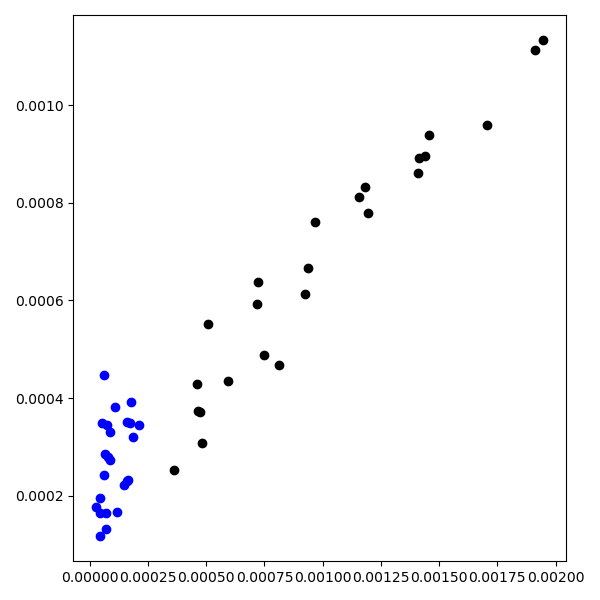

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
cs = ['k', 'b', 'r']
for mi, mid in enumerate(mids):
    x = dfbd[mid]['eps_LT83']
    y = dfbd[mid]['eps_phase']
    ax.scatter(x, y, color=cs[mi])

plt.tight_layout()
plt.show()

In [ ]:
mids

Plot $\epsilon$ vs. $U_\mathrm{rms}^3$.

U_rms        0.002727
intercept    0.000000
dtype: float64
U_rms        0.002546
intercept    0.000000
dtype: float64


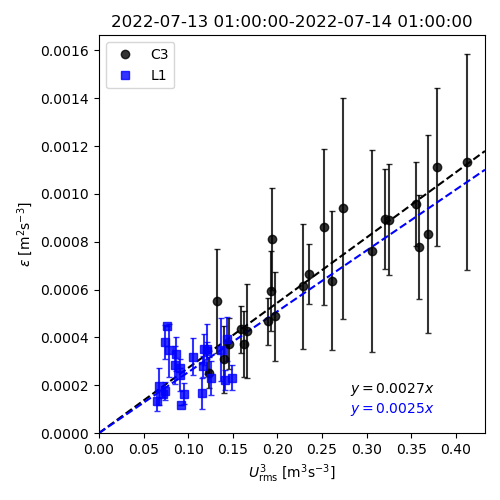

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
cs = ['k', 'b', 'r']
ms = ['o', 's', '^']
for mi, mid in enumerate(mids):
    x = (dfbd[mid]['U_rms']**3).to_frame()
    y = dfbd[mid]['eps_phase']
    ystd = dfbd[mid]['eps_phase_std']
    # Least squares fit, see:
    # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
    # Force intercept to be 0, see:
    # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
    model = sm.OLS(y, x.assign(intercept=0), missing='drop')
    results = model.fit()
    m, b = results.params
    print(results.params)
    # ax.scatter(x, y, color=cs[mi], label=mid, marker=ms[mi])
    ax.errorbar(x, y, yerr=ystd, color=cs[mi], label=mid, fmt=ms[mi],
                capsize=2, alpha=0.8)
    # Plot least squares fit
    ax.axline(xy1=(0, b), slope=m, color=cs[mi], linestyle='--')
    # Annotate least squares function
    s = f'$y = {m:.4f}x$'# {b:+.4f}$'
    ax.annotate(s, xy=(0.65, 0.10-mi*0.05), xycoords='axes fraction', 
                color=cs[mi])
# Labels
ax.set_xlabel(r'$U_\mathrm{rms}^3$ $[\mathrm{m}^3 \mathrm{s}^{-3}]$')
ax.set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')
ax.set_title('{}-{}'.format(t0, t1))

ax.set_xlim([0, None])
ax.set_ylim([0, None])

# Legend markers without errorbars
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax.legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.show()
# plt.close()
# plt.clf()

Plot heading, pitch & roll timeseries for C4 Vector around July 12-15.

mid:  C3
mid:  L1


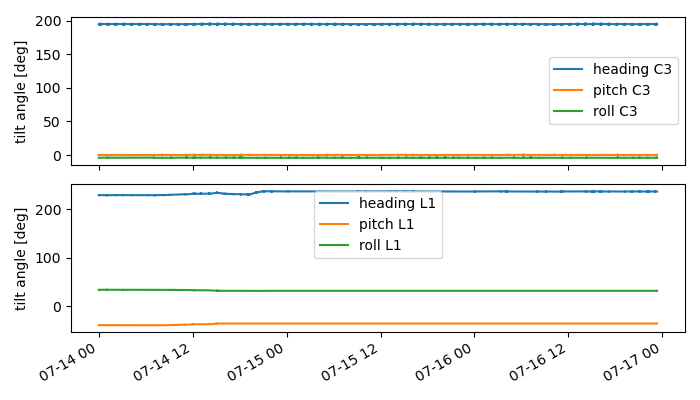

In [7]:
# mid = 'C4'
# ser = '17371'
# mid = 'L2'
# ser = '17376'
# mid = 'C3'
# ser = '17219'
# mid = 'L1'
# ser = '6338'
# mid = 'L5'
# ser = '6308'
mids = ['C3', 'L1']
sers = ['17219', '6338']
t0 = pd.Timestamp('2022-07-14 00:00:00')
t1 = pd.Timestamp('2022-07-16 00:00:00')
# Columns to read
cols = ['heading_ang', 'pitch_ang', 'roll_ang']
# Concatenate daily datasets
drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
# Initialize figure
fig, axes = plt.subplots(figsize=(7,4), nrows=2, sharex=True)
# Iterate over mooring IDs
for mi, (mid, ser) in enumerate(zip(mids, sers)):
    dlc = [] # List for concatenating
    print('mid: ', mid)
    for d in drc:
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
            ser, str(d.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
        # Only retain desired columns
        dsv = dsv[cols]
        # Append to list
        dlc.append(dsv)
    # Concatenate daily datasets
    dsv = xr.concat(dlc, dim='time')

    # Plot tilt angle timeseries
    dsv.heading_ang.plot(ax=axes[mi], label='heading {}'.format(mid))
    dsv.pitch_ang.plot(ax=axes[mi], label='pitch {}'.format(mid))
    dsv.roll_ang.plot(ax=axes[mi], label='roll {}'.format(mid))
for ax in axes:
    ax.set_xlabel(None)
    ax.set_ylabel('tilt angle [deg]')
    ax.legend()

plt.tight_layout()
plt.show()
# plt.clf()